# Predict reviews rating

In [6]:
# TODO: crossvalscore

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import enchant
import re
import string
from pprint import pprint
from time import time
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from textblob import Word, TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold, KFold
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = stopwords.words('english')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /Users/donor/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/donor/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/donor/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/donor/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [8]:
df = pd.read_csv('reviews.csv')
df

,Rating,Year_Month,Reviewer_Location,Review_Text
0,5,2019-3,United Arab Emirates,"We've been to Disneyland Hongkong and Tokyo, s..."
1,4,2018-6,United Kingdom,I went to Disneyland Paris in April 2018 on Ea...
2,5,2019-4,United Kingdom,"What a fantastic place, the queues were decent..."
3,4,2019-4,Australia,We didn't realise it was school holidays when ...
4,5,missing,France,A Trip to Disney makes you all warm and fuzzy ...
...,...,...,...,...
13625,5,missing,United Kingdom,i went to disneyland paris in july 03 and thou...
13626,5,missing,Canada,2 adults and 1 child of 11 visited Disneyland ...
13627,5,missing,South Africa,My eleven year old daughter and myself went to...
13628,4,missing,United States,"This hotel, part of the Disneyland Paris compl..."


## Exploration des données

#### Vérification des valeurs manquantes

In [9]:
df.isna().sum()

Rating               0
Year_Month           0
Reviewer_Location    0
Review_Text          0
dtype: int64

#### Contenu de la colonne Rating

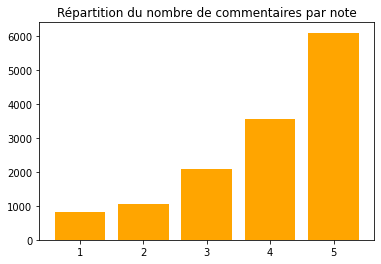

In [55]:
rating_count = df['Rating'].value_counts().sort_values(ascending=True)
plt.bar(range(1, 6), rating_count, color='orange')
plt.title('Répartition du nombre de commentaires par note');

#### Contenu de la colonne Review_Text

In [12]:
df['Review_Length'] = df['Review_Text'].str.split().map(lambda x: len(x))
# Suppression des reviews bizarres
df = df[df['Review_Length'] > 5]
df.sort_values(by='Review_Length', axis=0, ascending=True)

,Rating,Year_Month,Reviewer_Location,Review_Text,Review_Length
12440,3,2012-2,United Kingdom,Disappointed with size compared to florida cou...,7
12686,4,2011-10,United Kingdom,everything was fantastic but food prices exces...,7
11890,5,2012-6,United Kingdom,"Excellent but very crowded long queue, Great p...",8
12152,3,2012-1,United Kingdom,Mcdonalds style food but not the prices !!!!!!...,8
12455,5,2012-2,United Kingdom,"Disneyland as usual fabulous quality, but in...",8
...,...,...,...,...,...
5473,5,2016-2,United Kingdom,We have just returned from an amazing four nig...,2247
1518,5,2018-4,United Kingdom,Hi allHaving just returned from DLP I thought ...,2488
10262,2,2013-8,United Kingdom,Our experience at Disneyland Paris.First of ...,2515
12853,4,2011-8,Canada,This entire trip report with lots of pictures ...,3278


Longueur des reviews par note de 1 à 5 :



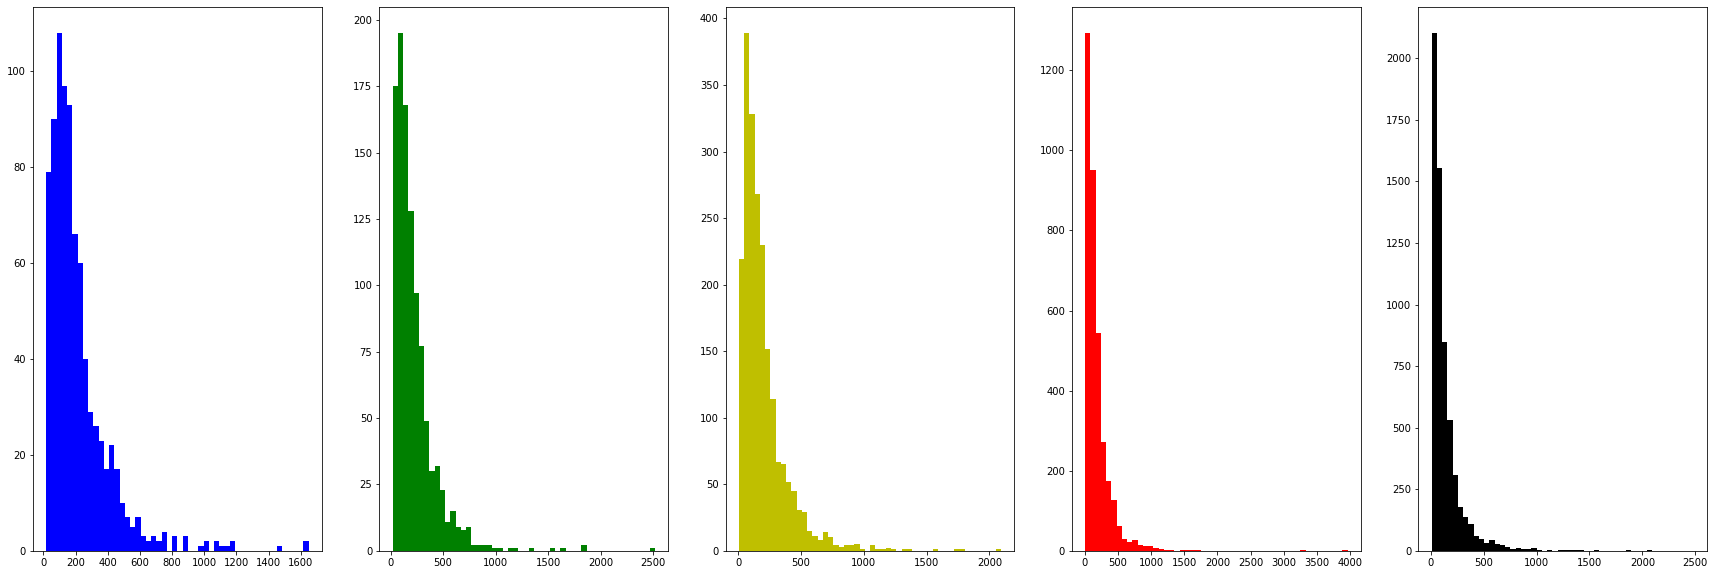

In [13]:
print('Longueur des reviews par note de 1 à 5 :\n')
plt.figure(figsize=(30, 10))
plt.subplot(151)
plt.hist(df[df['Rating'] == 1]['Review_Length'],bins=50, color='b')
plt.subplot(152)
plt.hist(df[df['Rating'] == 2]['Review_Length'],bins=50, color='g')
plt.subplot(153)
plt.hist(df[df['Rating'] == 3]['Review_Length'],bins=50, color='y')
plt.subplot(154)
plt.hist(df[df['Rating'] == 4]['Review_Length'],bins=50, color='r')
plt.subplot(155)
plt.hist(df[df['Rating'] == 5]['Review_Length'],bins=50, color='k');

## Preprocessing de la colonne Review_text

In [14]:
WordLemm = WordNetLemmatizer()
EnglishDict = enchant.Dict("en")

def preprocess_reviews(review):
    # print('Unprocessed review: \n', review, '\n')
    review = review.replace('[^\w\s]', '')
    # print('Removing leading whitespace: \n', review, '\n')
    review = review.translate(str.maketrans("","",string.punctuation))
    # print('Removing punctuation: \n', review, '\n')
    review = re.sub('[\d]', '', review)
    # print('Removing digits: \n', review, '\n')
    review = review.lower()
    # print('Lowercasing: \n', review, '\n')
    tokens = word_tokenize(review)
    # print('Tokenising: \n', tokens, '\n')
    tokens = [token for token in tokens if token not in stop_words]
    # print('Removing stopwords: \n', tokens, '\n')
    tokens = [WordLemm.lemmatize(token) for token in tokens if len(token) > 2]
    # print('Lemmatising and keeping words more than 2 letters: \n', tokens, '\n')
    tokens = [token for token in tokens if EnglishDict.check(token)]
    # print('Keeping well written words: \n', tokens, '\n')
    processed_review = ' '.join(tokens)
    # print('Processed review: \n', processed_review, '\n')
    return processed_review

In [15]:
df['processed_review'] = df['Review_Text'].apply(lambda x: preprocess_reviews(x))
df

/var/folders/m_/2w2qlxsn13s9qyf11rtgzkkr0000gn/T/ipykernel_83873/2245744766.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['processed_review'] = df['Review_Text'].apply(lambda x: preprocess_reviews(x))


,Rating,Year_Month,Reviewer_Location,Review_Text,Review_Length,processed_review
0,5,2019-3,United Arab Emirates,"We've been to Disneyland Hongkong and Tokyo, s...",91,far one best looking forward visit biggest one...
1,4,2018-6,United Kingdom,I went to Disneyland Paris in April 2018 on Ea...,176,went weekend know say cant choose date loved m...
2,5,2019-4,United Kingdom,"What a fantastic place, the queues were decent...",58,fantastic place queue decent best time year ap...
3,4,2019-4,Australia,We didn't realise it was school holidays when ...,148,realise school holiday went consequently extre...
4,5,missing,France,A Trip to Disney makes you all warm and fuzzy ...,133,trip make warm fuzzy actual kid big one make f...
...,...,...,...,...,...,...
13625,5,missing,United Kingdom,i went to disneyland paris in july 03 and thou...,173,went thought brilliant visited hotel stayed ba...
13626,5,missing,Canada,2 adults and 1 child of 11 visited Disneyland ...,191,adult child visited beginning absolute fantast...
13627,5,missing,South Africa,My eleven year old daughter and myself went to...,109,eleven year old daughter went visit son decide...
13628,4,missing,United States,"This hotel, part of the Disneyland Paris compl...",112,hotel part complex wonderful place family sinc...


### Comparaison longueur des reviews avant / après preprocessing

In [16]:
df['Review_Length_preprocessed'] = df['processed_review'].str.split().map(lambda x: len(x))
df['diff'] = df['Review_Length_preprocessed'] - df['Review_Length']
df['diff'].describe()

/var/folders/m_/2w2qlxsn13s9qyf11rtgzkkr0000gn/T/ipykernel_83873/2732557836.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Review_Length_preprocessed'] = df['processed_review'].str.split().map(lambda x: len(x))
/var/folders/m_/2w2qlxsn13s9qyf11rtgzkkr0000gn/T/ipykernel_83873/2732557836.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['diff'] = df['Review_Length_preprocessed'] - df['Review_Length']


count    13628.000000
mean       -95.753669
std        108.255683
min      -2356.000000
25%       -119.000000
50%        -63.000000
75%        -32.000000
max         -2.000000
Name: diff, dtype: float64

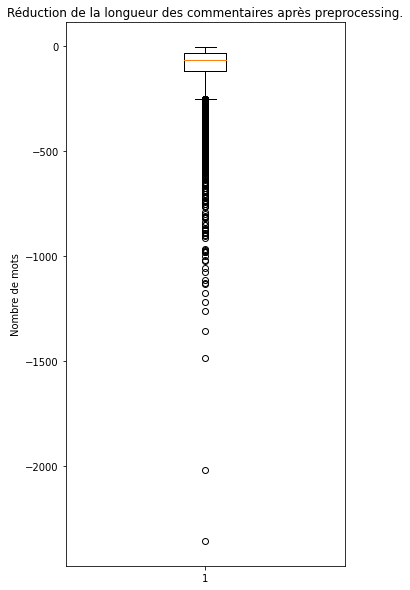

In [68]:
plt.figure(figsize=(5, 10))
plt.boxplot(df['diff'])
plt.ylabel('Nombre de mots')
plt.title('Réduction de la longueur des commentaires après preprocessing.');

### Exemples de reviews avant / après

In [17]:
print(f"Exemple review positive (note de {df.loc[20, 'Rating']}) avant / après processing :\n")
print(df.loc[20, 'Review_Text'], '\n')
print(df.loc[20, 'processed_review'])

Exemple review positive (note de 5) avant / après processing :

This was my first trip to Disneyland Paris and it was absolutely fantastic! The staff were extremely helpful! The park was but this was to be expected with the time I visited. I would highly recommend this park! The character parade and end of day show are literally incredible!!  

first trip absolutely fantastic staff extremely helpful park expected time visited would highly recommend park character parade end day show literally incredible


In [18]:
print(f"Exemple review positive (note de {df.loc[17, 'Rating']}) avant / après processing :\n")
print(df.loc[17, 'Review_Text'], '\n')
print(df.loc[17, 'processed_review'])

Exemple review positive (note de 1) avant / après processing :

Why they selling fastpass tickets without have buy before the entrance tickets???  Any answer ???  Shame on you!!!   We came here from Greece until the entrance!!!  Avoid this place!!!                                                                                                                 

selling ticket without buy entrance ticket answer shame came entrance avoid place


In [19]:
df

,Rating,Year_Month,Reviewer_Location,Review_Text,Review_Length,processed_review,Review_Length_preprocessed,diff
0,5,2019-3,United Arab Emirates,"We've been to Disneyland Hongkong and Tokyo, s...",91,far one best looking forward visit biggest one...,39,-52
1,4,2018-6,United Kingdom,I went to Disneyland Paris in April 2018 on Ea...,176,went weekend know say cant choose date loved m...,68,-108
2,5,2019-4,United Kingdom,"What a fantastic place, the queues were decent...",58,fantastic place queue decent best time year ap...,24,-34
3,4,2019-4,Australia,We didn't realise it was school holidays when ...,148,realise school holiday went consequently extre...,71,-77
4,5,missing,France,A Trip to Disney makes you all warm and fuzzy ...,133,trip make warm fuzzy actual kid big one make f...,58,-75
...,...,...,...,...,...,...,...,...
13625,5,missing,United Kingdom,i went to disneyland paris in july 03 and thou...,173,went thought brilliant visited hotel stayed ba...,68,-105
13626,5,missing,Canada,2 adults and 1 child of 11 visited Disneyland ...,191,adult child visited beginning absolute fantast...,70,-121
13627,5,missing,South Africa,My eleven year old daughter and myself went to...,109,eleven year old daughter went visit son decide...,43,-66
13628,4,missing,United States,"This hotel, part of the Disneyland Paris compl...",112,hotel part complex wonderful place family sinc...,54,-58


## Implémentation de l'algorithme

### Séparation du jeu de données avec cross validation

In [20]:
X = df['processed_review']
y = df['Rating']

In [21]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=21)
for train_index, test_index in folds.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [22]:
print('Dimensions données d\'entrainement: ', X_train.shape, y_train.shape)
print('Dimensions données test :', X_test.shape, y_test.shape)

Dimensions données d'entrainement:  (10903,) (10903,)
Dimensions données test : (2725,) (2725,)


### Modèle 1 avec CountVectorizer

#### Extraction des features numériques

In [23]:
CV = CountVectorizer(stop_words = 'english')
X_train_CV = CV.fit_transform(X_train)
X_test_CV = CV.transform(X_test)

In [24]:
CV_df = pd.DataFrame(X_train_CV.toarray(), columns=CV.get_feature_names())
CV_df

/Users/donor/PycharmProjects/de_job_market/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,ab,aback,abandon,abandoned,abbey,abbreviated,abhorrence,abhorrent,abide,ability,...,zing,zip,zipped,zippered,zipping,zombie,zone,zoned,zoo,zoom
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10898,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10899,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10900,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10901,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Entraînement du modèle

In [25]:
clf = MultinomialNB()
clf.fit(X_train_CV, y_train)

MultinomialNB()

In [26]:
print('Résultats Multinomial Naive Bayes données d\'entraînement :', clf.score(X_train_CV, y_train))
print('Résultats Multinomial Naive Bayes données test :', clf.score(X_test_CV, y_test))

Résultats Multinomial Naive Bayes données d'entraînement : 0.7271393194533614
Résultats Multinomial Naive Bayes données test : 0.5577981651376147


In [27]:
predicted_result = clf.predict(X_test_CV)
print(classification_report(y_test, predicted_result))

              precision    recall  f1-score   support

           1       0.52      0.22      0.31       165
           2       0.30      0.15      0.20       209
           3       0.40      0.41      0.40       417
           4       0.41      0.36      0.38       713
           5       0.68      0.84      0.75      1221

    accuracy                           0.56      2725
   macro avg       0.46      0.39      0.41      2725
weighted avg       0.53      0.56      0.53      2725



#### Interprétation des résultats

Le modèle est plus précis pour prédire les extrémités : 52% pour les notes de 1 et 68% pour les notes 5.
Cela montre les challenges de la classification de texte où les nuances sont difficiles à prendre en compte.

### Modèle 2 avec TfidfVectorizer

#### Extraction des features numériques

In [28]:
TV = TfidfVectorizer(stop_words = 'english')

X_train_tfidf = TV.fit_transform(X_train)
X_test_tfidf = TV.transform(X_test)

print(X_train_tfidf.shape)
print(X_test_tfidf.shape)

(10903, 12898)
(2725, 12898)


In [29]:
CV_tfidf = pd.DataFrame(X_train_tfidf.toarray(), columns=TV.get_feature_names())
CV_tfidf

/Users/donor/PycharmProjects/de_job_market/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,ab,aback,abandon,abandoned,abbey,abbreviated,abhorrence,abhorrent,abide,ability,...,zing,zip,zipped,zippered,zipping,zombie,zone,zoned,zoo,zoom
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10898,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10899,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10900,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10901,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Entraînement du modèle

In [30]:
clf2 = MultinomialNB()

clf2.fit(X_train_tfidf, y_train)
print(clf2.score(X_train_tfidf, y_train))

print (clf2.score(X_test_tfidf, y_test))

0.4841786664220857
0.45541284403669724


In [31]:
predicted_result_2 = clf2.predict(X_test_tfidf)
print(classification_report(y_test,predicted_result_2))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00       165
           2       0.00      0.00      0.00       209
           3       0.22      0.01      0.02       417
           4       0.12      0.03      0.05       713
           5       0.48      1.00      0.65      1221

    accuracy                           0.46      2725
   macro avg       0.16      0.21      0.14      2725
weighted avg       0.28      0.46      0.30      2725



/Users/donor/PycharmProjects/de_job_market/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/donor/PycharmProjects/de_job_market/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/donor/PycharmProjects/de_job_market/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

#### Interprétation des résultats

Le modèle est plus précis pour les notes qui comptent le plus de reviews : 48% de précision pour les notes 5 et 0 pour les notes 1 qui ont respectivement 6611 et 828 observations.

### Modèle 3 avec 2 classes

In [32]:
y = y.replace([1, 2, 3], 0)
y = y.replace([4, 5], 1)

In [33]:
y.value_counts()

1    9673
0    3955
Name: Rating, dtype: int64

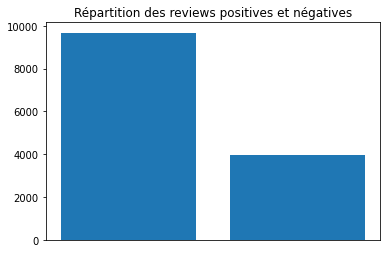

In [34]:
plt.bar(range(2), y.value_counts())
plt.title('Répartition des reviews positives et négatives')
plt.xticks([]);

In [35]:
folds = KFold(n_splits=5, shuffle=True, random_state=21)
for train_index, test_index in folds.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [36]:
CV = CountVectorizer(stop_words = 'english')
X_train_CV = CV.fit_transform(X_train)
X_test_CV = CV.transform(X_test)

In [37]:
cnb = ComplementNB()
cnb.fit(X_train_CV, y_train)

ComplementNB()

In [38]:
print('Résultats Complement Naive Bayes données d\'entraînement :', cnb.score(X_train_CV, y_train))
print('Résultats Complement Naive Bayes données test :', cnb.score(X_test_CV, y_test))

Résultats Complement Naive Bayes données d'entraînement : 0.8898468311473906
Résultats Complement Naive Bayes données test : 0.8539449541284404


In [39]:
predicted_result = cnb.predict(X_test_CV)
print(classification_report(y_test, predicted_result))

              precision    recall  f1-score   support

           0       0.77      0.76      0.77       858
           1       0.89      0.90      0.89      1867

    accuracy                           0.85      2725
   macro avg       0.83      0.83      0.83      2725
weighted avg       0.85      0.85      0.85      2725



#### Interprétation des résultats

Réduire le nombre de classes augmente la précision.
Le modèle est plus performant sur la classe positive qui compte 3 à 4 fois plus de données.

### Modèle 4 avec GridSearch

In [40]:
pipeline = Pipeline(
    [
        ("vect", CountVectorizer()),
        ("tfidf", TfidfTransformer()),
        ("clf", SGDClassifier()),
    ]
)

# uncommenting more parameters will give better exploring power but will
# increase processing time in a combinatorial way
parameters = {
    "vect__max_df": (0.5, 0.75, 1.0),
    # 'vect__max_features': (None, 5000, 10000, 50000),
    "vect__ngram_range": ((1, 1), (1, 2)),  # unigrams or bigrams
    # 'tfidf__use_idf': (True, False),
    # 'tfidf__norm': ('l1', 'l2'),
    "clf__max_iter": (20,),
    "clf__alpha": (0.00001, 0.000001),
    "clf__penalty": ("l2", "elasticnet"),
    # 'clf__max_iter': (10, 50, 80),
}

In [41]:
# find the best parameters for both the feature extraction and the
# classifier
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)

print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:")
pprint(parameters)

t0 = time()
grid_search.fit(X, y)

print("done in %0.3fs" % (time() - t0))
print()

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'clf__alpha': (1e-05, 1e-06),
 'clf__max_iter': (20,),
 'clf__penalty': ('l2', 'elasticnet'),
 'vect__max_df': (0.5, 0.75, 1.0),
 'vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 24 candidates, totalling 120 fits
done in 74.534s

Best score: 0.873
Best parameters set:
	clf__alpha: 1e-05
	clf__max_iter: 20
	clf__penalty: 'l2'
	vect__max_df: 0.75
	vect__ngram_range: (1, 2)


### Modèle 5 avec TextBlob

In [42]:
df['polarity'] = df['processed_review'].apply(lambda x: TextBlob(x).sentiment[0])

/var/folders/m_/2w2qlxsn13s9qyf11rtgzkkr0000gn/T/ipykernel_83873/3607210847.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['polarity'] = df['processed_review'].apply(lambda x: TextBlob(x).sentiment[0])


In [43]:
df[df['polarity'] > 0]

,Rating,Year_Month,Reviewer_Location,Review_Text,Review_Length,processed_review,Review_Length_preprocessed,diff,polarity
0,5,2019-3,United Arab Emirates,"We've been to Disneyland Hongkong and Tokyo, s...",91,far one best looking forward visit biggest one...,39,-52,0.287500
1,4,2018-6,United Kingdom,I went to Disneyland Paris in April 2018 on Ea...,176,went weekend know say cant choose date loved m...,68,-108,0.468750
2,5,2019-4,United Kingdom,"What a fantastic place, the queues were decent...",58,fantastic place queue decent best time year ap...,24,-34,0.135185
3,4,2019-4,Australia,We didn't realise it was school holidays when ...,148,realise school holiday went consequently extre...,71,-77,0.138026
4,5,missing,France,A Trip to Disney makes you all warm and fuzzy ...,133,trip make warm fuzzy actual kid big one make f...,58,-75,0.243750
...,...,...,...,...,...,...,...,...,...
13625,5,missing,United Kingdom,i went to disneyland paris in july 03 and thou...,173,went thought brilliant visited hotel stayed ba...,68,-105,0.252778
13626,5,missing,Canada,2 adults and 1 child of 11 visited Disneyland ...,191,adult child visited beginning absolute fantast...,70,-121,0.161053
13627,5,missing,South Africa,My eleven year old daughter and myself went to...,109,eleven year old daughter went visit son decide...,43,-66,0.212500
13628,4,missing,United States,"This hotel, part of the Disneyland Paris compl...",112,hotel part complex wonderful place family sinc...,54,-58,0.274603


In [44]:
df[df['polarity'] < 0]

,Rating,Year_Month,Reviewer_Location,Review_Text,Review_Length,processed_review,Review_Length_preprocessed,diff,polarity
8,2,2019-4,Greece,"We booked tickets on line for Disneyland, this...",216,booked ticket line something recommend line al...,87,-129,-0.035870
12,5,2019-4,Malta,This is a place everyone deserves to go at lea...,62,place everyone deserves least life time enter ...,27,-35,-0.111111
15,5,2019-4,Saudi Arabia,"I had been there twice with my grandson, I wi...",36,twice grandson never give grandson never good ...,13,-23,-0.216667
24,5,2018-12,Israel,we have traveled during December. the day was ...,51,traveled day bit rainy crowded went dining big...,20,-31,-0.200000
27,1,2019-4,United Kingdom,Its a shame this park carry the name Disney......,178,shame park carry name build place year back co...,81,-97,-0.030303
...,...,...,...,...,...,...,...,...,...
13576,2,missing,United Kingdom,Not what I had expected having visited the 2 A...,133,expected visited theme park found village smel...,52,-81,-0.029365
13607,2,missing,United Kingdom,We've just come back from a couple of days at ...,186,come back couple day agree previous review wri...,63,-123,-0.037879
13609,1,missing,United States,Having spent three days at the Disneyland Pari...,160,spent three day resort nothing praise park ent...,71,-89,-0.065000
13610,2,missing,Switzerland,"The parades were great, but the bathrooms were...",27,parade great bathroom filthy could trying hard...,12,-15,-0.135417


In [45]:
df[df['polarity'] < 0]['Rating'].value_counts()

1    405
3    393
2    336
4    245
5    195
Name: Rating, dtype: int64

In [46]:
df[df['polarity'] > 0]['Rating'].value_counts()

5    5876
4    3299
3    1679
2     704
1     418
Name: Rating, dtype: int64